# Machine Failure Prediction

## Libraries Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
import os
import re
import numpy as np
import time

## Dataset Import

In [2]:
df = pd.read_csv('predictive_maintenance.csv')

## EDA

Effettuiamo ora l'analisi del dataset:

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.shape

(10000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Le feature presenti sono le seguenti:
- **UDI** : Unique Device Identifier, ovvero un identificatore dell'istanza, univoco per ogni riga del dataset.
- **Product ID** : Identificatore del prodotto, univoco per ogni prodotto.
- **Type** : Feature categorica che indica la qualità del prodotto; assume valori discreti nel range [L, M, H], dove L='low Quality', M='Medium Quality', H='High Quality'.
- **Air Temperature** : Temperatura dell'aria in Kelvin (K), che potrebbe essere un parametro rilevante per il processo di produzione, indicando potenzialmente le condizioni ambientali o le impostazioni delle macchine.
- **Process Temperature** : Questa caratteristica si riferisce alla temperatura di processo in Kelvin (K). Può essere un parametro critico nel processo di produzione, che influisce sulla qualità del prodotto e sul funzionamento della macchina.
- **Rotational Speed** : Questa caratteristica rappresenta la velocità di rotazione delle macchine, che viene calcolata in base alla potenza e include un rumore normalmente distribuito. È un parametro essenziale per comprendere il funzionamento della macchina ed è espresso in rotazioni per minuto (rpm).
- **Torque** : Questa caratteristica indica il momento della forza, applicata dalle macchine durante il processo di produzione; è l'equivalente rotazionale del concetto fisico di forza ed è espresso in Newton per metri (Nm).
- **Tool Wear** : La caratteristica rappresenta lo stato di usura dell'utensile in termini di minuti di utilizzo ed è associata alle varianti di qualità (H/M/L). Suggerisce che gli utensili sono utilizzati insieme alle macchine durante il processo di produzione.
- **Target** : Questa è la variabile target del dataset, che rappresenta se la macchina possa avere un guasto oppure no. Questa è una variabile binaria, dove 1 indica che la macchina si è guastata e 0 indica che la macchina non si è guastata.
- **Failure Type** : Questa etichetta indica se la macchina si è guastata e, se si, quale guasto ha avuto. Ciò suggerisce che il set di dati include informazioni sui guasti delle macchine e che il set di dati può includere diversi tipi di macchine con diverse modalità di guasto.

Il dataset è composto da 10000 righe.

Verifichiamo che il dataset non contenga ne valori nulli o Nan, ne duplicati:

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [8]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Per le nostre analisi non ci servono le colonne contenenti gli identificatori univoci delle macchine, quindi le rimuoviamo così come la colonna 'Failure Type', poichè ci concentreremo sulla classificazione binaria della variabile target 'Target'. 

In [9]:
df.drop(['UDI', 'Product ID', 'Failure Type'], axis=1, inplace=True)
df.rename(columns={"Air temperature [K]":"Air Temperature", "Process temperature [K]":"Process Temperature", "Rotational speed [rpm]":"Rotational Speed", "Torque [Nm]":"Torque", "Tool wear [min]":"Tool Wear"}, inplace=True)

In [10]:
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


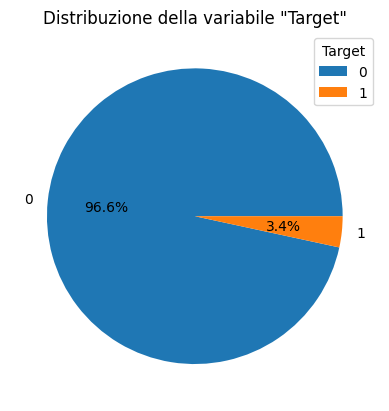

In [11]:
target = df["Target"].value_counts()

plt.pie(target, labels=["0", "1"], autopct='%1.1f%%')
plt.legend(title="Target")
plt.title("Distribuzione della variabile \"Target\"")
plt.show()

Vediamo come il dataset risulti essere sbilanciatoin favore della classe 0, ovvero la classe che indica che la macchina non si è guastata. Sarà quindi necessario effettuare un ribilanciamento di esso.

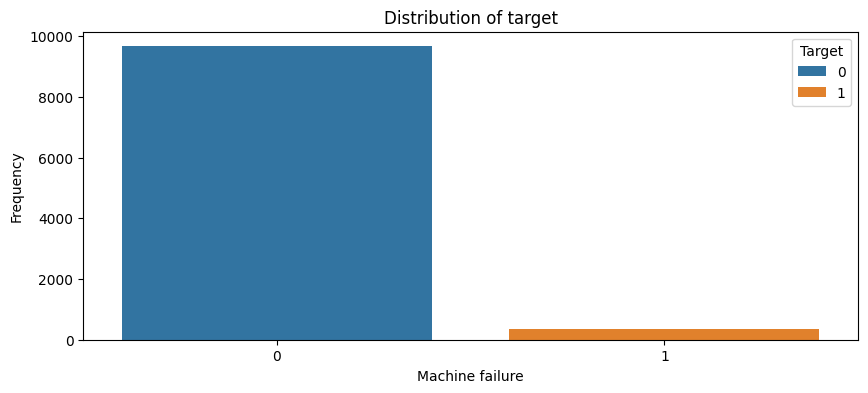

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Target', data=df, hue='Target')
plt.title("Distribution of target")
plt.xlabel("Machine failure")
plt.ylabel("Frequency")
plt.show()

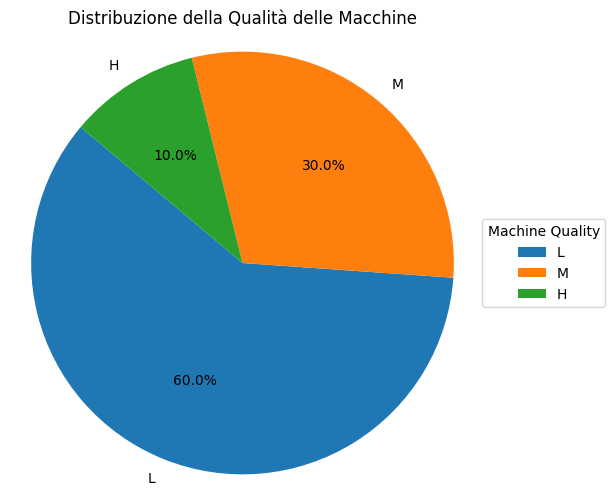

In [23]:
# Extracting the unique machine qualities and their counts
machine_qualities = df['Type'].value_counts()
labels = machine_qualities.index
counts = machine_qualities.values

# Creating the pie chart with more descriptive labels and a legend
plt.figure(figsize=(6, 6))  # Adjusting figure size for better readability
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione della Qualità delle Macchine')
plt.legend(labels, title="Machine Quality", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

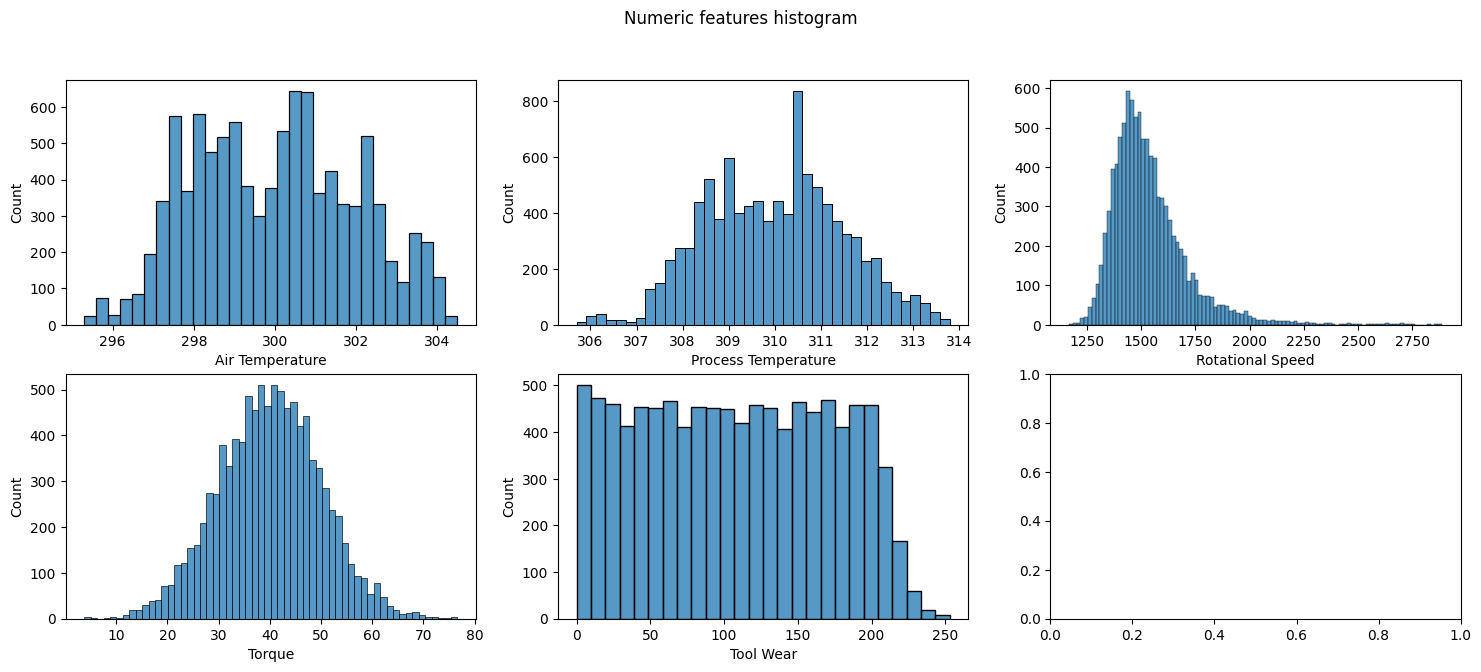

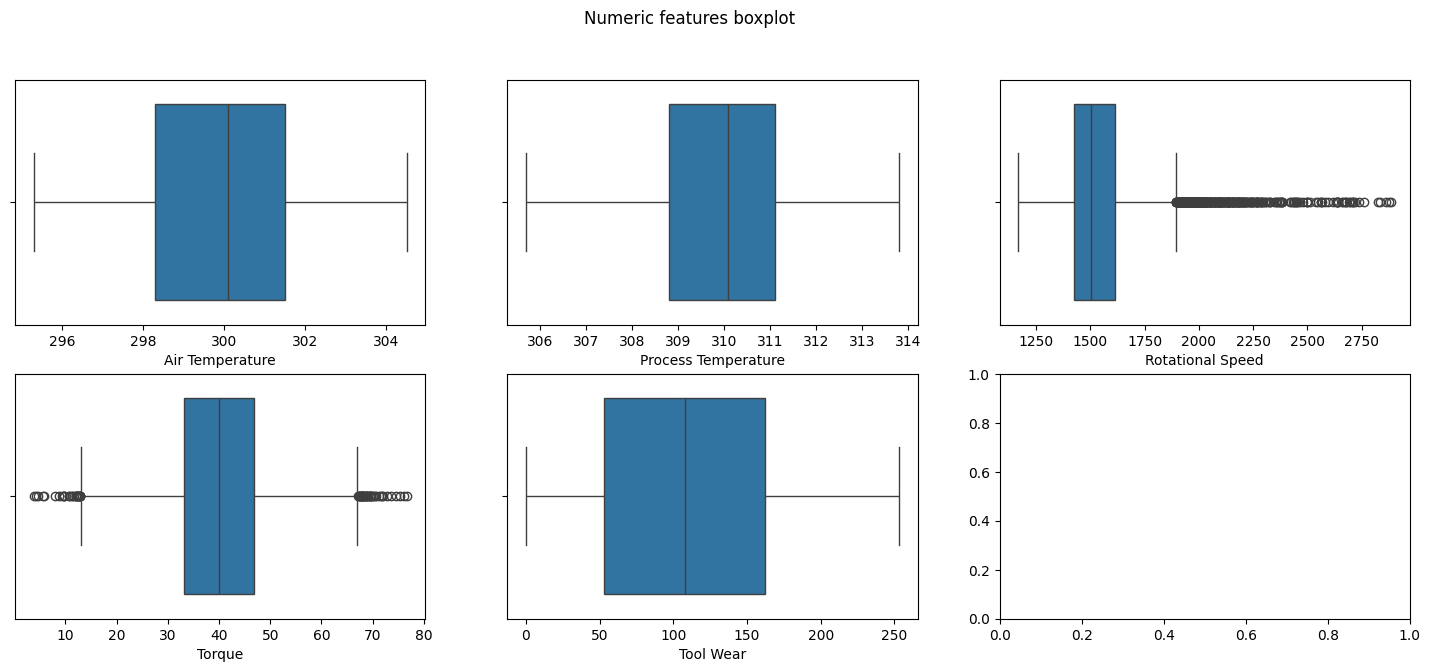

In [ ]:
num_features = [feature for feature in df.drop(['Target', 'Type'], axis=1)]
# Histograms of numeric features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

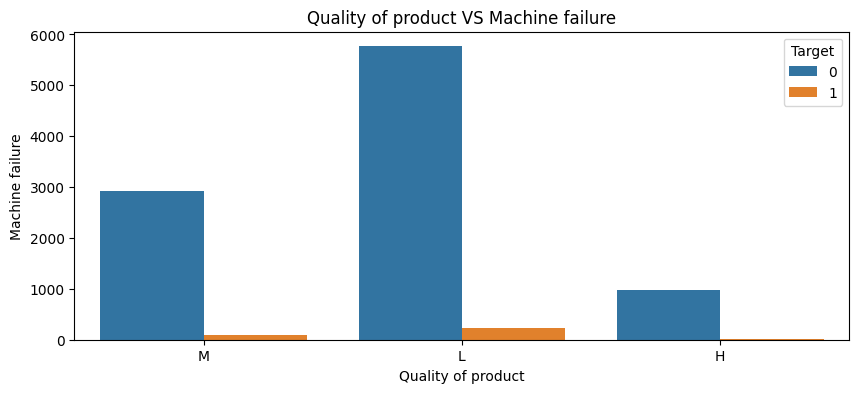

In [14]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Type', hue='Target')
plt.title('Quality of product VS Machine failure')
plt.xlabel('Quality of product')
plt.ylabel('Machine failure')
plt.show()

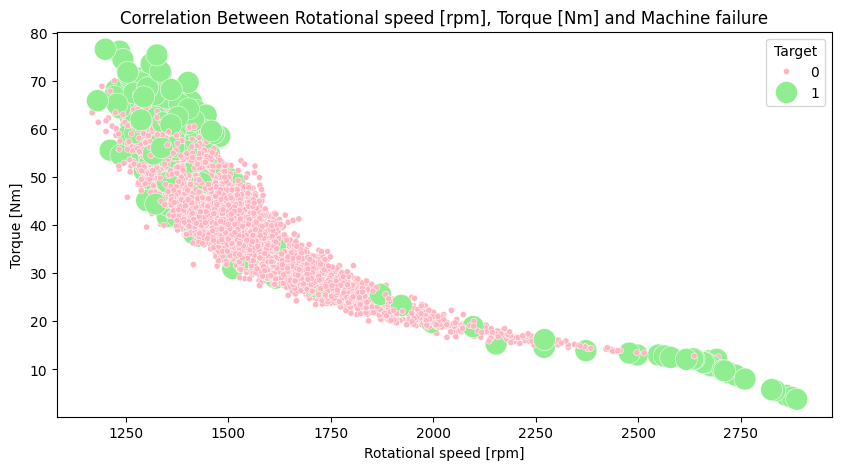

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Rotational Speed', y='Torque', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(250, 20))
plt.title('Correlation Between Rotational speed [rpm], Torque [Nm] and Machine failure')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()

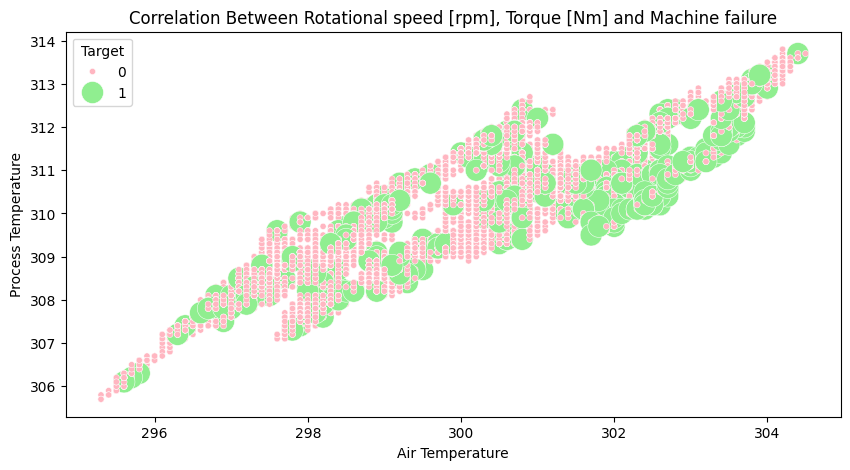

In [18]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Air Temperature', y='Process Temperature', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(250, 20))
plt.title('Correlation Between Rotational speed [rpm], Torque [Nm] and Machine failure')
plt.xlabel('Air Temperature')
plt.ylabel('Process Temperature')
plt.show()

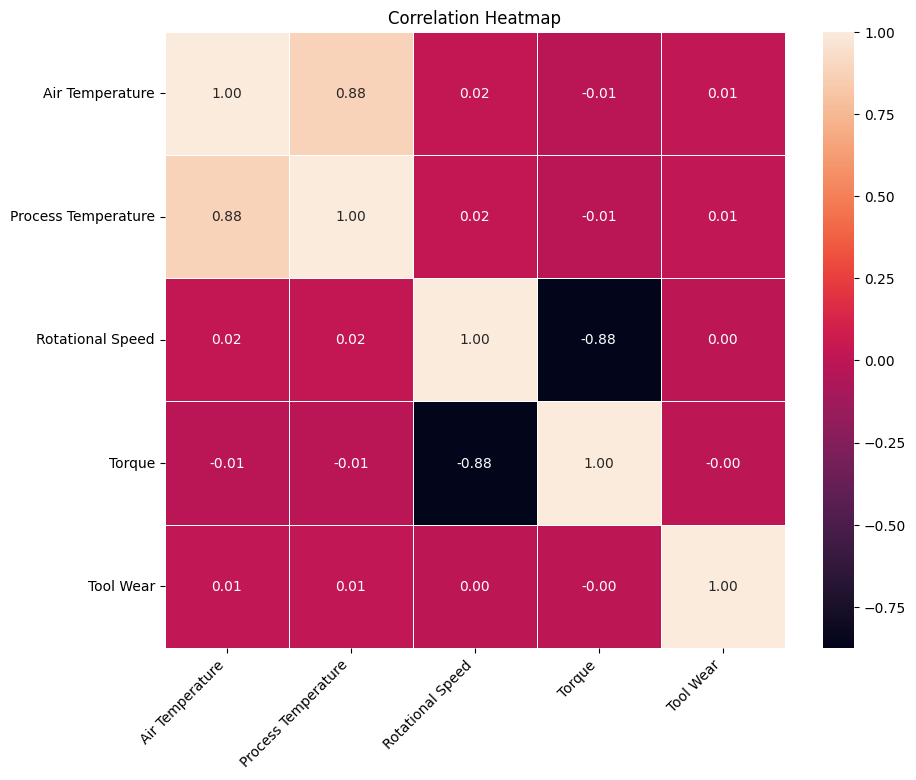

In [24]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()